In [1]:
%matplotlib inline

In [3]:
import os
import random
import pickle
import numpy as np
import tensorflow as tf

from model import c2v
from data import build_vocab

# config
config = {
    'batch_size'      : 16,
    'embed_size'      : 200,
    'neg_sample_size' : 100,
}

# data
data, unique_neg_data, idx2word, word2idx, vocab = build_vocab()

name2idx = dict([(name, idx) for idx, name in enumerate(data.keys())])
idx2name = dict([(idx, name) for idx, name in enumerate(data.keys())])

vocab_size = len(idx2word)
character_size = len(data)

config['vocab_size'] = vocab_size
config['character_size'] = character_size

# model
pos_x, pos_y, neg_y, train, loss, nembed, nearby_character, nearby_val, nearby_idx = c2v(config)

# train
step_size = 100000
learning_rate = 0.025
window_size = 5
min_count = 5
subsample = 1e-3

batch_idx = 0
data_idx = {}

for i in xrange(len(data)):
    data_idx[i] = 0

def generate_batch(config, data, unique_neg_data):
    global batch_idx, data_idx

    batch_size = config['batch_size']
    neg_sample_size = config['neg_sample_size']

    batch = data.values()[batch_idx]
    neg_batch = unique_neg_data.values()[batch_idx]
    idx = data_idx[batch_idx]

    data_pos_x = np.ones(batch_size) * batch_idx
    data_pos_y = np.ndarray(shape=batch_size, dtype=np.int32)
    data_neg_y = np.ndarray(shape=neg_sample_size, dtype=np.int32)

    for i in xrange(batch_size):
        data_pos_y[i] = batch[idx]
        idx = (idx + 1) % len(batch)

    for i, neg_y_idx in enumerate(random.sample(set(neg_batch), neg_sample_size)):
        data_neg_y[i] = neg_y_idx

    data_idx[batch_idx] = idx
    batch_idx = (batch_idx + 1) % len(data)

    return data_pos_x, data_pos_y, data_neg_y

batch_pkl = "./batch.pkl"

if os.path.isfile(batch_pkl):
    batch = pickle.load(open(batch_pkl))
else:
    batch = []
    for i in xrange(step_size):
        batch.append(generate_batch(config, data, unique_neg_data))

    pickle.dump(batch, open(batch_pkl, "wb"))

sess = tf.InteractiveSession()

#with tf.Session() as sess:
if True:
    sess.run(tf.initialize_all_variables())
    average_loss = 0

    batch_size = config['batch_size']
    neg_sample_size = config['neg_sample_size']

    for step in xrange(step_size):
        data_pos_x, data_pos_y, data_neg_y = batch[step]
        feed_dict = {pos_x: data_pos_x, pos_y: np.reshape(data_pos_y, (batch_size)), neg_y: np.reshape(data_neg_y, (neg_sample_size))}
        _, loss_val = sess.run([train, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000

            print("Average loss at step ", step, ": ", average_loss)
            acharacter_sizeverage_loss = 0

def nearby(words, num=20):
    ids = np.array([name2idx.get(x, 0) for x in words])
    vals, idx = sess.run(
        [nearby_val, nearby_idx], {nearby_character: ids})
    for i in xrange(len(words)):
        print(words[i])
        print()
        for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
            print("%-20s %6.4f" % (idx2name[neighbor], distance))

def nearby_with_idx(idxs, num=20):
    ids = np.array(idxs)
    vals, idx = sess.run(
        [nearby_val, nearby_idx], {nearby_character: ids})
    for i in xrange(len(idxs)):
        print(idx2name[idxs[i]])
        print()
        for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
            print("%-20s %6.4f" % (idx2name[neighbor], distance))

('Average loss at step ', 0, ': ', 70.004547119140625)
('Average loss at step ', 2000, ': ', 69.46092517852783)
('Average loss at step ', 4000, ': ', 68.310821210422517)
('Average loss at step ', 6000, ': ', 67.178413039999754)
('Average loss at step ', 8000, ': ', 66.050817886176986)
('Average loss at step ', 10000, ': ', 64.917071128089816)
('Average loss at step ', 12000, ': ', 63.756502784144978)
('Average loss at step ', 14000, ': ', 62.541552014667218)
('Average loss at step ', 16000, ': ', 61.221786185476937)
('Average loss at step ', 18000, ': ', 59.729807227931602)
('Average loss at step ', 20000, ': ', 57.986992247745441)
('Average loss at step ', 22000, ': ', 55.856294408980929)
('Average loss at step ', 24000, ': ', 53.190263996966451)
('Average loss at step ', 26000, ': ', 49.864886426096383)
('Average loss at step ', 28000, ': ', 45.75676111943681)
('Average loss at step ', 30000, ': ', 40.938881161474029)
('Average loss at step ', 32000, ': ', 35.676741853834521)
('Avera

In [4]:
names = name2idx.keys()

In [5]:
embed_size = config.get('embed_size', 200)
batch_size = config.get('batch_size', 16)
neg_sample_size = config.get('neg_sample_size', 100)

nearby_emb = tf.reshape(tf.gather(nembed, nearby_character), [1, embed_size])
nearby_dist = tf.matmul(nearby_emb, nembed, transpose_b=True)

In [9]:
sim = np.ndarray([len(names), len(names)])

for i in xrange(len(names)):
    sim[i] = nearby_dist.eval({nearby_character:[i]})

In [10]:
sim

array([[ 0.99999982,  0.99743593,  0.99756449, ...,  0.99715912,
         0.99693054,  0.99752611],
       [ 0.99743593,  1.00000024,  0.99752402, ...,  0.99771428,
         0.99762505,  0.99737245],
       [ 0.99756449,  0.99752402,  1.00000012, ...,  0.99702245,
         0.99720818,  0.99758887],
       ..., 
       [ 0.99715912,  0.99771428,  0.99702245, ...,  1.00000012,
         0.99712873,  0.9972496 ],
       [ 0.99693054,  0.99762505,  0.99720818, ...,  0.99712873,
         0.99999982,  0.99704218],
       [ 0.99752611,  0.99737245,  0.99758887, ...,  0.9972496 ,
         0.99704218,  0.99999958]])

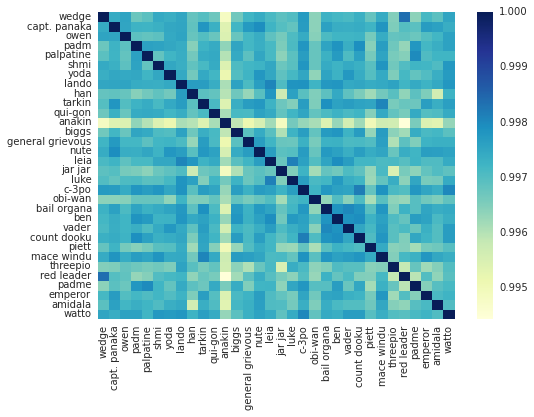

In [11]:
import seaborn
seaborn.heatmap(sim, xticklabels=names, yticklabels=names, cmap="YlGnBu")

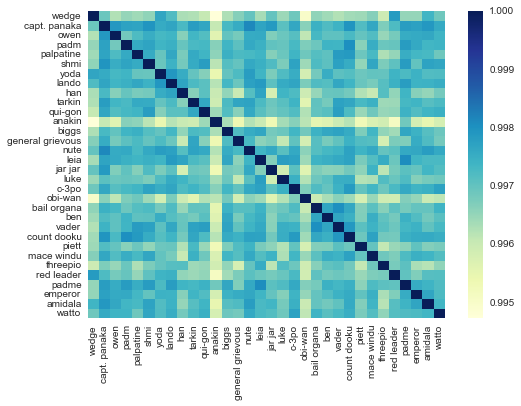

In [46]:
import seaborn
seaborn.heatmap(sim, xticklabels=names, yticklabels=names, cmap="YlGnBu")

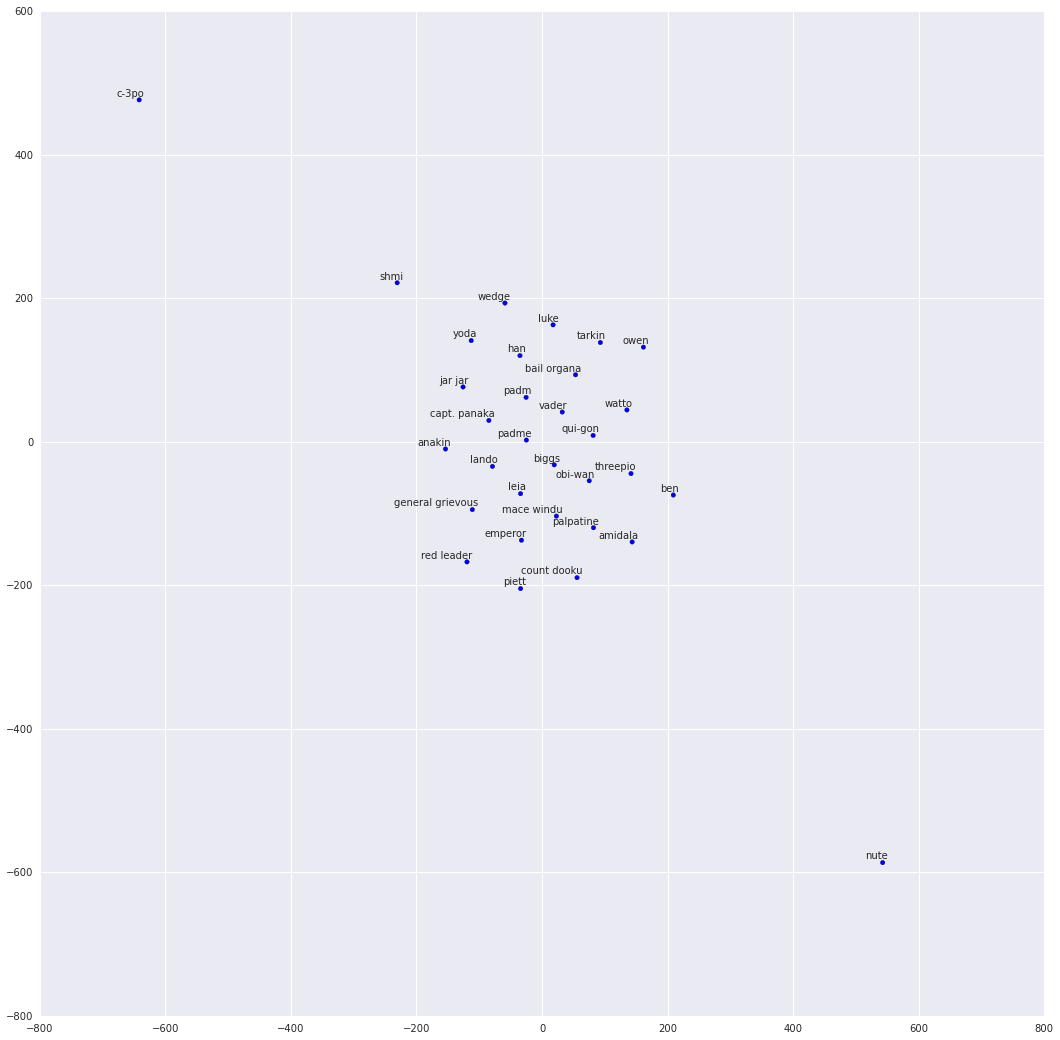

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

def plot_with_labels(low_dim_embs, labels, filename='p2v.png'):
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

plot_only = 500
plot_with_labels(tsne.fit_transform(nembed.eval()[:plot_only,:]), names)

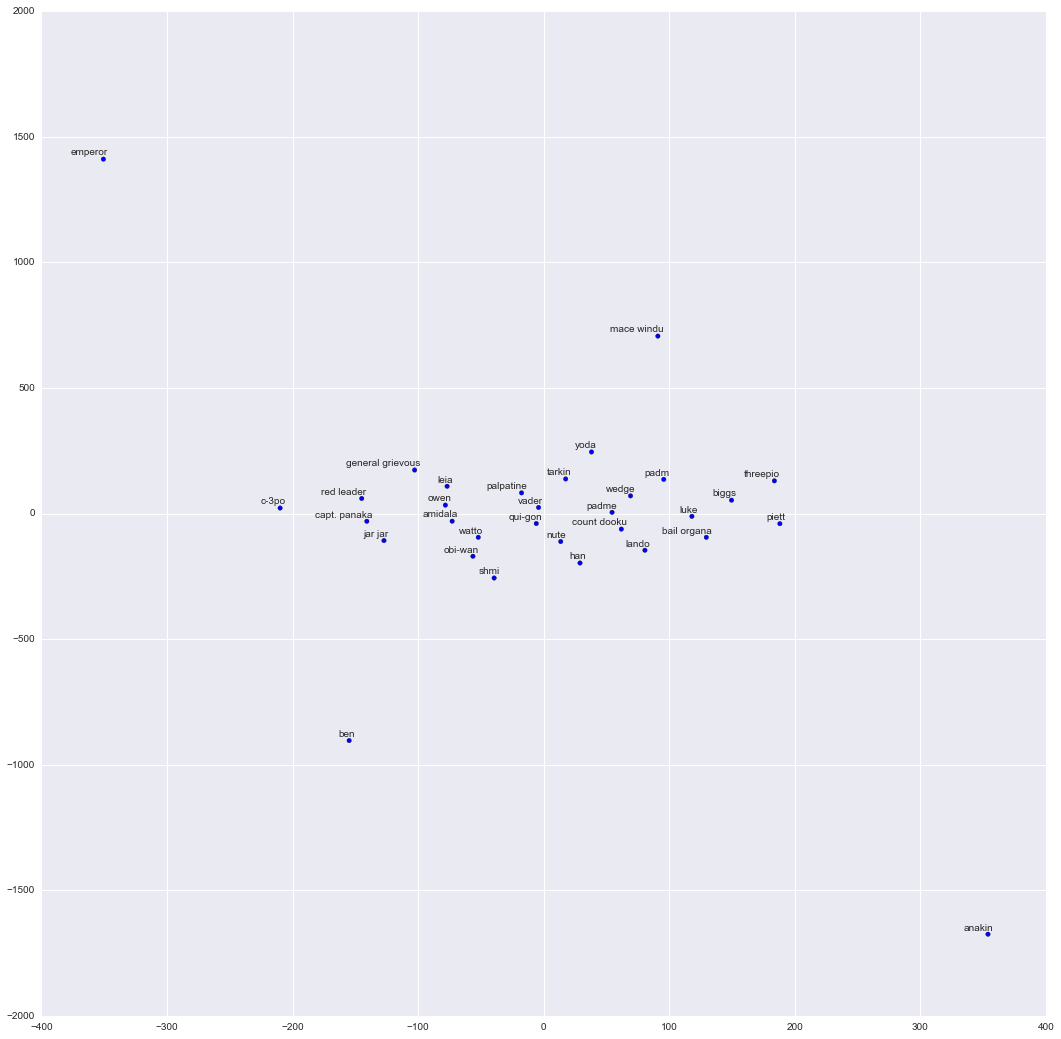

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

def plot_with_labels(low_dim_embs, labels, filename='p2v.png'):
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

plot_only = 500
plot_with_labels(tsne.fit_transform(nembed.eval()[:plot_only,:]), names)